In [1]:
import json
import os.path
import numpy as np
from collections import defaultdict
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
ADJECTIVES_COLORS_ANIMATE = {"black_cat", "brown_dog", "white_horse", "black_bird"}
ADJECTIVES_COLORS_INANIMATE = {"red_bus", "white_truck", "blue_bus", "white_boat"}

ADJECTIVES_SIZES_ANIMATE = {"big_bird", "small_cat", "big_cat", "small_dog"}
ADJECTIVES_SIZES_INANIMATE = {"small_plane", "big_plane", "small_table", "big_truck"}

VERBS_TRANSITIVE = {"eat_man", "ride_woman", "hold_child", "eat_horse"}
VERBS_INTRANSITIVE = {"lie_woman", "fly_bird", "stand_bird", "stand_child"}

all_pairs = ADJECTIVES_COLORS_ANIMATE.union(ADJECTIVES_COLORS_INANIMATE).union(ADJECTIVES_SIZES_ANIMATE)\
                                     .union(ADJECTIVES_SIZES_INANIMATE).union(VERBS_TRANSITIVE).union(VERBS_INTRANSITIVE)

In [3]:
def read_pair_recalls(mdir, concept_pairs, at=5, split='test', beam=5, rr=False):
    if rr:
        fn = 'recall_%d.%s.re_ranking.beam_%d.%s' % (at, '%s', beam, split)
    else:
        fn = 'recall_%d.%s.beam_%d.%s' % (at, '%s', beam, split)
    basefile = mdir + fn
    results = dict()
    for pair in concept_pairs:
        fn = basefile % pair
        if os.path.isfile(fn):
            with open(fn) as f:
                recall_score = json.load(f)
            results[pair] = recall_score
    return results

def calc_recall(recall_score, min_importance=1):
    return np.sum(list(recall_score["true_positives"].values())[min_importance - 1:]) / \
            np.sum(list(recall_score["numbers"].values())[min_importance - 1:])

def average_recall(recall_scores, min_importance=1):
    pair_recalls_summed = 0
    length = 0

    for i, pair in enumerate(recall_scores.keys()):
        average_pair_recall = np.sum(list(recall_scores[pair]["true_positives"].values())[min_importance - 1:]) / \
                              np.sum(list(recall_scores[pair]["numbers"].values())[min_importance - 1:])
        if not np.isnan(average_pair_recall):
            pair_recalls_summed += average_pair_recall
            length += 1

    recall = 100 * pair_recalls_summed / length
    return recall

In [4]:
ix2group = {k: v for k, v in enumerate([ADJECTIVES_COLORS_ANIMATE, ADJECTIVES_COLORS_INANIMATE, 
                                        ADJECTIVES_SIZES_ANIMATE, ADJECTIVES_SIZES_INANIMATE,
                                        VERBS_TRANSITIVE, VERBS_INTRANSITIVE])}
pair2ix = {p: ix for ix, g in ix2group.items() for p in g}

# Break-down of planning approaches and composition categories

In [5]:
split = 'val'
recall_at = 5
beam = 100
basedir = "../experiments/"

In [6]:
def get_dict(model2dirs, latex=False):
    model2recalls = {m: {i+1: read_pair_recalls(mdir, all_pairs, recall_at, split, beam, rr=('+rr' in m)) 
                         for i, mdir in enumerate(mdirs)} 
                     for m, mdirs in model2dirs.items()}

    model2pair2metrics = {}
    for model, values in model2recalls.items():
        model2pair2metrics[model] = dict()
        for val in values.values():
            for pair, metrics in val.items():
                model2pair2metrics[model][pair] = metrics

    model2group2avg_recall = {}
    for model, ix2pair2metrics in model2recalls.items():
        group2metrics = defaultdict(dict)
        for ix, pair2metrics in ix2pair2metrics.items():
            for pair, recall_score in pair2metrics.items():
                group2metrics[pair2ix[pair]][pair] = recall_score
        model2group2avg_recall[model] = {gix: average_recall(pair2metrics) for gix, pair2metrics in group2metrics.items()}
        
    if latex:
        print("\\textbf{Model} & \\textbf{Color} & \\textbf{Size} & \\textbf{Verb}\\\\")
        print(" & \\textbf{A} & \\textbf{I} & \\textbf{A} & \\textbf{I} & \\textbf{T} & \\textbf{I}\\\\")
        for model, group2avg_recall in model2group2avg_recall.items():
            print(model.upper() + ' ', end='')
            for gix in ix2group:
                print("& %.1f " % group2avg_recall[gix], end='')
            print('\\\\')
    
    return model2group2avg_recall

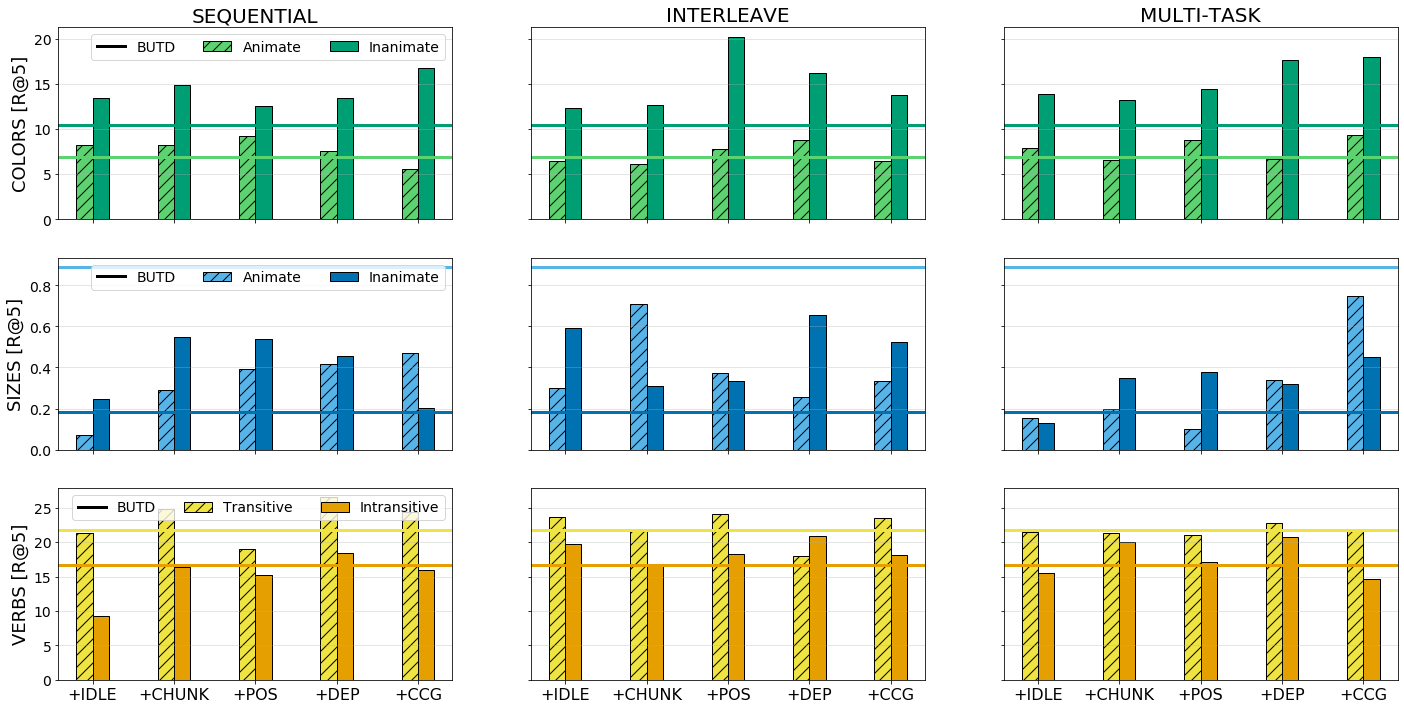

In [7]:
f, axs = plt.subplots(3,3, figsize=(24,12), sharey='row', sharex=True)
w = 0.2
# cmap = matplotlib.cm.get_cmap('Paired')
# colors = cmap.colors
colors = ['#5DD271', '#009E73', '#56B4E9', '#0072B2', '#F0E442', '#E69F00']
xs = ['+idle', '+chunk', '+pos', '+dep', '+ccg']

# Sequential
model2dirs = {
    'butd': [basedir+'coco_heldout_%d/butd/results/' % d for d in range(1,4+1)],
    'butd+idle': [basedir+'coco_heldout_%d_idle_seq/butd/results/' % d for d in range(1,4+1)],
    'butd+chunk': [basedir+'coco_heldout_%d_chunk_seq/butd/results/' % d for d in range(1,4+1)],
    'butd+pos': [basedir+'coco_heldout_%d_pos_seq/butd/results/' % d for d in range(1,4+1)],
    'butd+dep': [basedir+'coco_heldout_%d_dep_seq/butd/results/' % d for d in range(1,4+1)],
    'butd+ccg': [basedir+'coco_heldout_%d_ccg_seq/butd/results/' % d for d in range(1,4+1)],
}
model2group2avg_recall = get_dict(model2dirs)

ax = axs[0,0]
ax.axhline(y=model2group2avg_recall['butd'][0], color=colors[0], linewidth=3) #, linestyle='--')
ax.axhline(y=model2group2avg_recall['butd'][1], color=colors[1], linewidth=3)#, linestyle='-.')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][0])
ax.bar(np.arange(len(xs))-w/2, ys, width=w, color=colors[0], edgecolor='black', hatch='//')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][1])
ax.bar(np.arange(len(xs))+w/2, ys, width=w, color=colors[1], edgecolor='black')
ax.grid(axis='y', alpha=0.4)
ax.set_title("SEQUENTIAL", fontsize=20)
ax.set_ylabel("COLORS [R@5]", fontsize=18)
ax.yaxis.set_tick_params(labelsize=14)
line = Line2D([0], [0], color='k', linewidth=3, linestyle='-')
patch1 = mpatches.Patch(facecolor=colors[0], edgecolor='black', hatch='//')
patch2 = mpatches.Patch(facecolor=colors[1], edgecolor='black')
# labels = ['black data', 'red data', 'green data']
ax.legend(handles=[line, patch1, patch2], labels=['BUTD', 'Animate', 'Inanimate'], ncol=3, fontsize=14)

ax = axs[1,0]
ax.axhline(y=model2group2avg_recall['butd'][2], color=colors[2], linewidth=3, linestyle='-')
ax.axhline(y=model2group2avg_recall['butd'][3], color=colors[3], linewidth=3, linestyle='-')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][2])
ax.bar(np.arange(len(xs))-w/2, ys, width=w, color=colors[2], edgecolor='black', hatch='//')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][3])
ax.bar(np.arange(len(xs))+w/2, ys, width=w, color=colors[3], edgecolor='black')
ax.grid(axis='y', alpha=0.4)
ax.set_ylabel("SIZES [R@5]", fontsize=18)
ax.yaxis.set_tick_params(labelsize=14)
line = Line2D([0], [0], color='k', linewidth=3, linestyle='-')
patch1 = mpatches.Patch(facecolor=colors[2], edgecolor='black', hatch='//')
patch2 = mpatches.Patch(facecolor=colors[3], edgecolor='black')
# labels = ['black data', 'red data', 'green data']
ax.legend(handles=[line, patch1, patch2], labels=['BUTD', 'Animate', 'Inanimate'], ncol=3, fontsize=14)


ax = axs[2,0]
ax.axhline(y=model2group2avg_recall['butd'][4], color=colors[4], linewidth=3, linestyle='-')
ax.axhline(y=model2group2avg_recall['butd'][5], color=colors[5], linewidth=3, linestyle='-')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][4])
ax.bar(np.arange(len(xs))-w/2, ys, width=w, color=colors[4], edgecolor='black', hatch='//')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][5])
ax.bar(np.arange(len(xs))+w/2, ys, width=w, color=colors[5], edgecolor='black')
ax.grid(axis='y', alpha=0.4)
ax.set_xticklabels(['']+[x.upper() for x in xs], fontsize=16)
ax.set_ylabel("VERBS [R@5]", fontsize=18)
ax.yaxis.set_tick_params(labelsize=14)
line = Line2D([0], [0], color='k', linewidth=3, linestyle='-')
patch1 = mpatches.Patch(facecolor=colors[4], edgecolor='black', hatch='//')
patch2 = mpatches.Patch(facecolor=colors[5], edgecolor='black')
# labels = ['black data', 'red data', 'green data']
ax.legend(handles=[line, patch1, patch2], labels=['BUTD', 'Transitive', 'Intransitive'], ncol=3, fontsize=14)


# Interleave
model2dirs = {
    'butd': [basedir+'coco_heldout_%d/butd/results/' % d for d in range(1,4+1)],
    'butd+idle': [basedir+'coco_heldout_%d_idle_inter/butd/results/' % d for d in range(1,4+1)],
    'butd+chunk': [basedir+'coco_heldout_%d_chunk_inter/butd/results/' % d for d in range(1,4+1)],
    'butd+pos': [basedir+'coco_heldout_%d_pos_inter/butd/results/' % d for d in range(1,4+1)],
    'butd+dep': [basedir+'coco_heldout_%d_dep_inter/butd/results/' % d for d in range(1,4+1)],
    'butd+ccg': [basedir+'coco_heldout_%d_ccg_inter/butd/results/' % d for d in range(1,4+1)],
}
model2group2avg_recall = get_dict(model2dirs)

ax = axs[0,1]
ax.axhline(y=model2group2avg_recall['butd'][0], color=colors[0], linewidth=3, linestyle='-')
ax.axhline(y=model2group2avg_recall['butd'][1], color=colors[1], linewidth=3, linestyle='-')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][0])
ax.bar(np.arange(len(xs))-w/2, ys, width=w, color=colors[0], edgecolor='black', hatch='//')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][1])
ax.bar(np.arange(len(xs))+w/2, ys, width=w, color=colors[1], edgecolor='black')
ax.grid(axis='y', alpha=0.4)
ax.set_title("INTERLEAVE", fontsize=20)

ax = axs[1,1]
ax.axhline(y=model2group2avg_recall['butd'][2], color=colors[2], linewidth=3, linestyle='-')
ax.axhline(y=model2group2avg_recall['butd'][3], color=colors[3], linewidth=3, linestyle='-')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][2])
ax.bar(np.arange(len(xs))-w/2, ys, width=w, color=colors[2], edgecolor='black', hatch='//')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][3])
ax.bar(np.arange(len(xs))+w/2, ys, width=w, color=colors[3], edgecolor='black')
ax.grid(axis='y', alpha=0.4)

ax = axs[2,1]
ax.axhline(y=model2group2avg_recall['butd'][4], color=colors[4], linewidth=3, linestyle='-')
ax.axhline(y=model2group2avg_recall['butd'][5], color=colors[5], linewidth=3, linestyle='-')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][4])
ax.bar(np.arange(len(xs))-w/2, ys, width=w, color=colors[4], edgecolor='black', hatch='//')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][5])
ax.bar(np.arange(len(xs))+w/2, ys, width=w, color=colors[5], edgecolor='black')
ax.grid(axis='y', alpha=0.4)
ax.set_xticklabels(['']+[x.upper() for x in xs], fontsize=16)


# Multi-task
model2dirs = {
    'butd': [basedir+'coco_heldout_%d/butd/results/' % d for d in range(1,4+1)],
    'butd+idle': [basedir+'coco_heldout_%d_idle_multi/butd/results/' % d for d in range(1,4+1)],
    'butd+chunk': [basedir+'coco_heldout_%d_chunk_multi/butd/results/' % d for d in range(1,4+1)],
    'butd+pos': [basedir+'coco_heldout_%d_pos_multi/butd/results/' % d for d in range(1,4+1)],
    'butd+dep': [basedir+'coco_heldout_%d_dep_multi/butd/results/' % d for d in range(1,4+1)],
    'butd+ccg': [basedir+'coco_heldout_%d_ccg_multi/butd/results/' % d for d in range(1,4+1)],
}
model2group2avg_recall = get_dict(model2dirs)

ax = axs[0,2]
ax.axhline(y=model2group2avg_recall['butd'][0], color=colors[0], linewidth=3, linestyle='-')
ax.axhline(y=model2group2avg_recall['butd'][1], color=colors[1], linewidth=3, linestyle='-')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][0])
ax.bar(np.arange(len(xs))-w/2, ys, width=w, color=colors[0], edgecolor='black', hatch='//')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][1])
ax.bar(np.arange(len(xs))+w/2, ys, width=w, color=colors[1], edgecolor='black')
ax.grid(axis='y', alpha=0.4)
ax.set_title("MULTI-TASK", fontsize=20)

ax = axs[1,2]
ax.axhline(y=model2group2avg_recall['butd'][2], color=colors[2], linewidth=3, linestyle='-')
ax.axhline(y=model2group2avg_recall['butd'][3], color=colors[3], linewidth=3, linestyle='-')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][2])
ax.bar(np.arange(len(xs))-w/2, ys, width=w, color=colors[2], edgecolor='black', hatch='//')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][3])
ax.bar(np.arange(len(xs))+w/2, ys, width=w, color=colors[3], edgecolor='black')
ax.grid(axis='y', alpha=0.4)

ax = axs[2,2]
ax.axhline(y=model2group2avg_recall['butd'][4], color=colors[4], linewidth=3, linestyle='-')
ax.axhline(y=model2group2avg_recall['butd'][5], color=colors[5], linewidth=3, linestyle='-')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][4])
ax.bar(np.arange(len(xs))-w/2, ys, width=w, color=colors[4], edgecolor='black', hatch='//')
ys = []
for m in xs:
    ys.append(model2group2avg_recall['butd' + m][5])
ax.bar(np.arange(len(xs))+w/2, ys, width=w, color=colors[5], edgecolor='black')
ax.grid(axis='y', alpha=0.4)
ax.set_xticklabels(['']+[x.upper() for x in xs], fontsize=16);

# plt.savefig('detailed_recall_butd.pdf', bbox_inches='tight')

# Performance per category & concept pair

In [8]:
split = 'val'
recall_at = 5
basedir = "../experiments/"
model2dirs = {
              'butd': [basedir+'coco_heldout_%d/butd/results/' % d for d in range(1,4+1)],
              'butd+idle': [basedir+'coco_heldout_%d_idle_inter/butd/results/' % d for d in range(1,4+1)],
              'butd+chunk': [basedir+'coco_heldout_%d_chunk_inter/butd/results/' % d for d in range(1,4+1)],
              'butd+pos': [basedir+'coco_heldout_%d_pos_inter/butd/results/' % d for d in range(1,4+1)],
              'butd+dep': [basedir+'coco_heldout_%d_dep_inter/butd/results/' % d for d in range(1,4+1)],
             }

model2recalls = {m: {i+1: read_pair_recalls(mdir, all_pairs, recall_at, split, beam, rr=('+rr' in m)) 
                     for i, mdir in enumerate(mdirs)} 
                 for m, mdirs in model2dirs.items()}
model2pair2metrics = dict()
for model, values in model2recalls.items():
    model2pair2metrics[model] = dict()
    for val in values.values():
        for pair, metrics in val.items():
            model2pair2metrics[model][pair] = metrics

In [9]:
print('\\textbf{Concept pair} ', end='')
for model in model2dirs:
    print('& \\textbf{%s} ' % model.upper(), end='')
print('\\\\')
for pair in model2pair2metrics[model]:
    print('%s ' % pair, end='')
    for model in model2dirs:
        print('& %.1f ' % (100*calc_recall(model2pair2metrics[model][pair])), end='')
    print('\\\\')

\textbf{Concept pair} & \textbf{BUTD} & \textbf{BUTD+IDLE} & \textbf{BUTD+CHUNK} & \textbf{BUTD+POS} & \textbf{BUTD+DEP} \\
red_bus & 16.1 & 26.7 & 18.6 & 24.0 & 24.6 \\
eat_man & 19.0 & 23.0 & 21.8 & 24.5 & 21.4 \\
black_cat & 16.1 & 6.9 & 4.4 & 15.3 & 14.9 \\
small_plane & 0.2 & 0.2 & 0.0 & 0.0 & 0.0 \\
lie_woman & 17.5 & 20.5 & 23.4 & 18.5 & 21.5 \\
big_bird & 2.4 & 0.5 & 1.9 & 0.9 & 0.5 \\
small_cat & 1.2 & 0.0 & 0.8 & 0.4 & 0.4 \\
fly_bird & 21.8 & 25.1 & 18.5 & 25.5 & 29.2 \\
brown_dog & 1.7 & 4.1 & 1.1 & 0.5 & 0.8 \\
big_plane & 0.5 & 0.7 & 0.5 & 0.6 & 1.0 \\
white_truck & 17.6 & 13.9 & 14.7 & 30.6 & 23.7 \\
ride_woman & 27.3 & 31.0 & 28.5 & 30.2 & 26.0 \\
stand_bird & 18.4 & 21.9 & 11.3 & 18.6 & 21.5 \\
hold_child & 17.8 & 20.0 & 9.7 & 19.8 & 11.0 \\
big_cat & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
small_table & 0.0 & 0.0 & 0.0 & 0.0 & 0.4 \\
white_horse & 4.9 & 7.5 & 13.1 & 10.9 & 14.6 \\
blue_bus & 6.5 & 7.2 & 17.0 & 22.7 & 14.8 \\
small_dog & 0.0 & 0.7 & 0.1 & 0.1 & 0.1 \\
black_bir

In [10]:
ix2group = {k: v for k, v in enumerate([ADJECTIVES_COLORS_ANIMATE, ADJECTIVES_COLORS_INANIMATE, 
                                        ADJECTIVES_SIZES_ANIMATE, ADJECTIVES_SIZES_INANIMATE,
                                        VERBS_TRANSITIVE, VERBS_INTRANSITIVE])}
pair2ix = {p: ix for ix, g in ix2group.items() for p in g}

model2group2avg_recall = {}
for model, ix2pair2metrics in model2recalls.items():
    group2metrics = defaultdict(dict)
    for ix, pair2metrics in ix2pair2metrics.items():
        for pair, recall_score in pair2metrics.items():
            group2metrics[pair2ix[pair]][pair] = recall_score
    model2group2avg_recall[model] = {gix: average_recall(pair2metrics) for gix, pair2metrics in group2metrics.items()}

print("\\textbf{Model} & \\textbf{Color} & \\textbf{Size} & \\textbf{Verb}\\\\")
print(" & \\textbf{A} & \\textbf{I} & \\textbf{A} & \\textbf{I} & \\textbf{T} & \\textbf{I}\\\\")
for model, group2avg_recall in model2group2avg_recall.items():
    print(model.upper() + ' ', end='')
    for gix in ix2group:
        print("& %.1f " % group2avg_recall[gix], end='')
    print('\\\\')

\textbf{Model} & \textbf{Color} & \textbf{Size} & \textbf{Verb}\\
 & \textbf{A} & \textbf{I} & \textbf{A} & \textbf{I} & \textbf{T} & \textbf{I}\\
BUTD & 6.9 & 10.4 & 0.9 & 0.2 & 21.8 & 16.7 \\
BUTD+IDLE & 6.4 & 12.3 & 0.3 & 0.6 & 23.7 & 19.7 \\
BUTD+CHUNK & 6.1 & 12.6 & 0.7 & 0.3 & 21.8 & 16.5 \\
BUTD+POS & 7.8 & 20.2 & 0.4 & 0.3 & 24.1 & 18.2 \\
BUTD+DEP & 8.8 & 16.2 & 0.3 & 0.7 & 18.0 & 20.9 \\


## Test

In [11]:
split = 'test'
recall_at = 5
basedir = "../experiments/"
model2dirs = {
              'butd': [basedir+'coco_heldout_%d/butd/results/' % d for d in range(1,4+1)],
              'butd+idle': [basedir+'coco_heldout_%d_idle_inter/butd/results/' % d for d in range(1,4+1)],
              'butd+chunk': [basedir+'coco_heldout_%d_chunk_inter/butd/results/' % d for d in range(1,4+1)],
              'butd+pos': [basedir+'coco_heldout_%d_pos_inter/butd/results/' % d for d in range(1,4+1)],
              'butd+dep': [basedir+'coco_heldout_%d_dep_inter/butd/results/' % d for d in range(1,4+1)],
              'butr+rr': [basedir+'coco_heldout_%d/butr/results/' % d for d in range(1,4+1)],
             }

model2recalls = {m: {i+1: read_pair_recalls(mdir, all_pairs, recall_at, split, beam, rr=('+rr' in m)) 
                     for i, mdir in enumerate(mdirs)} 
                 for m, mdirs in model2dirs.items()}
model2pair2metrics = dict()
for model, values in model2recalls.items():
    model2pair2metrics[model] = dict()
    for val in values.values():
        for pair, metrics in val.items():
            model2pair2metrics[model][pair] = metrics

In [12]:
print('\\textbf{Concept pair} ', end='')
for model in model2dirs:
    print('& \\textbf{%s} ' % model.upper(), end='')
print('\\\\')
for pair in model2pair2metrics[model]:
    print('%s ' % pair, end='')
    for model in model2dirs:
        print('& %.1f ' % (100*calc_recall(model2pair2metrics[model][pair])), end='')
    print('\\\\')

\textbf{Concept pair} & \textbf{BUTD} & \textbf{BUTD+IDLE} & \textbf{BUTD+CHUNK} & \textbf{BUTD+POS} & \textbf{BUTD+DEP} & \textbf{BUTR+RR} \\
red_bus & 17.8 & 21.3 & 16.1 & 22.2 & 25.2 & 36.5 \\
eat_man & 13.2 & 22.0 & 17.2 & 21.6 & 19.6 & 18.8 \\
black_cat & 13.7 & 4.5 & 4.0 & 17.0 & 14.1 & 22.9 \\
small_plane & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
lie_woman & 22.1 & 19.3 & 22.1 & 17.9 & 20.7 & 29.0 \\
big_bird & 1.6 & 0.0 & 1.6 & 0.8 & 0.0 & 2.5 \\
small_cat & 1.3 & 0.7 & 1.3 & 0.7 & 0.0 & 1.3 \\
fly_bird & 23.6 & 20.5 & 21.3 & 22.8 & 26.0 & 18.9 \\
brown_dog & 2.3 & 7.2 & 3.6 & 1.6 & 2.3 & 4.3 \\
big_plane & 0.0 & 0.0 & 0.3 & 0.6 & 1.1 & 2.0 \\
white_truck & 16.4 & 16.4 & 19.8 & 24.1 & 22.4 & 21.6 \\
ride_woman & 25.3 & 31.4 & 26.0 & 29.5 & 26.3 & 37.5 \\
stand_bird & 20.0 & 20.8 & 9.4 & 18.1 & 20.4 & 18.5 \\
hold_child & 17.5 & 19.7 & 10.8 & 20.7 & 15.4 & 22.1 \\
big_cat & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
small_table & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
white_horse & 7.7 & 7

In [13]:
print('\\textbf{Concept pair} ', end='')
for model in model2dirs:
    print('& \\textbf{%s} ' % model.upper(), end='')
print('\\\\')
for pair in model2pair2metrics[model]:
    print('%s ' % pair, end='')
    for model in model2dirs:
        print('& %.1f ' % (100*calc_recall(model2pair2metrics[model][pair])), end='')
    print('\\\\')

\textbf{Concept pair} & \textbf{BUTD} & \textbf{BUTD+IDLE} & \textbf{BUTD+CHUNK} & \textbf{BUTD+POS} & \textbf{BUTD+DEP} & \textbf{BUTR+RR} \\
red_bus & 17.8 & 21.3 & 16.1 & 22.2 & 25.2 & 36.5 \\
eat_man & 13.2 & 22.0 & 17.2 & 21.6 & 19.6 & 18.8 \\
black_cat & 13.7 & 4.5 & 4.0 & 17.0 & 14.1 & 22.9 \\
small_plane & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
lie_woman & 22.1 & 19.3 & 22.1 & 17.9 & 20.7 & 29.0 \\
big_bird & 1.6 & 0.0 & 1.6 & 0.8 & 0.0 & 2.5 \\
small_cat & 1.3 & 0.7 & 1.3 & 0.7 & 0.0 & 1.3 \\
fly_bird & 23.6 & 20.5 & 21.3 & 22.8 & 26.0 & 18.9 \\
brown_dog & 2.3 & 7.2 & 3.6 & 1.6 & 2.3 & 4.3 \\
big_plane & 0.0 & 0.0 & 0.3 & 0.6 & 1.1 & 2.0 \\
white_truck & 16.4 & 16.4 & 19.8 & 24.1 & 22.4 & 21.6 \\
ride_woman & 25.3 & 31.4 & 26.0 & 29.5 & 26.3 & 37.5 \\
stand_bird & 20.0 & 20.8 & 9.4 & 18.1 & 20.4 & 18.5 \\
hold_child & 17.5 & 19.7 & 10.8 & 20.7 & 15.4 & 22.1 \\
big_cat & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
small_table & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
white_horse & 7.7 & 7

In [14]:
ix2group = {k: v for k, v in enumerate([ADJECTIVES_COLORS_ANIMATE, ADJECTIVES_COLORS_INANIMATE, 
                                        ADJECTIVES_SIZES_ANIMATE, ADJECTIVES_SIZES_INANIMATE,
                                        VERBS_TRANSITIVE, VERBS_INTRANSITIVE])}
pair2ix = {p: ix for ix, g in ix2group.items() for p in g}

model2group2avg_recall = {}
for model, ix2pair2metrics in model2recalls.items():
    group2metrics = defaultdict(dict)
    for ix, pair2metrics in ix2pair2metrics.items():
        for pair, recall_score in pair2metrics.items():
            group2metrics[pair2ix[pair]][pair] = recall_score
    model2group2avg_recall[model] = {gix: average_recall(pair2metrics) for gix, pair2metrics in group2metrics.items()}

print("\\textbf{Model} & \\textbf{Color} & \\textbf{Size} & \\textbf{Verb}\\\\")
print(" & \\textbf{A} & \\textbf{I} & \\textbf{A} & \\textbf{I} & \\textbf{T} & \\textbf{I}\\\\")
for model, group2avg_recall in model2group2avg_recall.items():
    print(model.upper() + ' ', end='')
    for gix in ix2group:
        print("& %.1f " % group2avg_recall[gix], end='')
    print('\\\\')

\textbf{Model} & \textbf{Color} & \textbf{Size} & \textbf{Verb}\\
 & \textbf{A} & \textbf{I} & \textbf{A} & \textbf{I} & \textbf{T} & \textbf{I}\\
BUTD & 7.0 & 11.1 & 0.8 & 0.0 & 17.3 & 18.8 \\
BUTD+IDLE & 6.3 & 11.5 & 0.5 & 0.1 & 22.0 & 18.0 \\
BUTD+CHUNK & 6.9 & 12.5 & 0.7 & 0.1 & 20.3 & 16.2 \\
BUTD+POS & 7.8 & 16.7 & 0.5 & 0.3 & 23.6 & 17.5 \\
BUTD+DEP & 8.8 & 16.3 & 0.1 & 0.7 & 17.9 & 19.5 \\
BUTR+RR & 12.1 & 21.2 & 1.0 & 0.6 & 27.1 & 20.2 \\
